In [1]:
import numpy as np
import pandas as pd
import os

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy.optimize import lsq_linear
def unmixing(features, cell, n_feature):
    b = features['ave_intensity'].loc[cell][: n_feature] 
    wls = features['wavelengths'].loc[cell][: n_feature]

    A = np.empty((len(b), len(mols)))
    for wl in wls:
        for i, mol in enumerate(mols):
            j = [j for j, col in enumerate(dfs[mol].columns[:-1]) 
                 if (dfs[mol].columns[j] <= wl[0] < dfs[mol].columns[j+1])][0]
            if wl[0] - dfs[mol].columns[j] > dfs[mol].columns[j + 1]- wl[0]:
                j += 1
            ex = dfs[mol].columns[j]

            k = [k for k, idx in enumerate(dfs[mol].index[:-1]) 
                 if (dfs[mol].index[k] > wl[1] >= dfs[mol].index[k+1])][0]
            if dfs[mol].index[k] - wl[1] < wl[1] - dfs[mol].index[k + 1]:
                k += 1
            em = dfs[mol].index[k]

            A[wls.index(wl), i] = dfs[mol].at[em, ex]
    res = lsq_linear(A, b, bounds=(0, np.inf), method='trf')

    return res

In [3]:
fdn_save = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/'
with open(fdn_save + 'bkg_sub_features.pkl','rb') as f:
    features = pickle.load(f)
features = features.set_index('image')

In [14]:
mols = ['Free NAD(P)H', 'Protein bound NAD(P)H'] # lipofusionA

fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/matrix_data_range/'
dfs = {name: pd.read_csv(fdn + name.replace(' ', '_') + '.tsv', sep='\t', index_col=0) for name in mols}

for mol in mols:
    dfs[mol].index = dfs[mol].index.astype('float')
    dfs[mol].columns = dfs[mol].columns.astype('float')

In [5]:
n_feature = 7

abundance = pd.DataFrame([], columns=mols)
for cell in features.index:
    abundance.loc[cell] = unmixing(features, cell, n_feature)['x']

In [6]:
abundance.to_csv('/home/yike/phd/cancer_cells_img_seq/data/unmixing/abundance_2mols.tsv', sep='\t')

# Linear least squares

In [8]:
# load features
fdn_save = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/'
with open(fdn_save + 'bkg_sub_features.pkl','rb') as f:
    features = pickle.load(f)
features = features.set_index('image')

# load matrix
mols = ['Free NAD(P)H', 'Protein bound NAD(P)H'] # lipofusionA

fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/matrix_data_range/'
dfs = {name: pd.read_csv(fdn + name.replace(' ', '_') + '.tsv', sep='\t', index_col=0) for name in mols}

for mol in mols:
    dfs[mol].index = dfs[mol].index.astype('float')
    dfs[mol].columns = dfs[mol].columns.astype('float')
    
# load abundance
abundance = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/data/unmixing/abundance_2mols.tsv', 
                        sep='\t', index_col=0)

In [38]:
def LLS(features, cell, n_feature):
    b = np.array(features['ave_intensity'].loc[cell][: n_feature])
    wls = features['wavelengths'].loc[cell][: n_feature]

    A = np.empty((len(b), len(mols)))
    for wl in wls:
        for i, mol in enumerate(mols):
            j = [j for j, col in enumerate(dfs[mol].columns[:-1]) 
                 if (dfs[mol].columns[j] <= wl[0] < dfs[mol].columns[j+1])][0]
            if wl[0] - dfs[mol].columns[j] > dfs[mol].columns[j + 1]- wl[0]:
                j += 1
            ex = dfs[mol].columns[j]

            k = [k for k, idx in enumerate(dfs[mol].index[:-1]) 
                 if (dfs[mol].index[k] > wl[1] >= dfs[mol].index[k+1])][0]
            if dfs[mol].index[k] - wl[1] < wl[1] - dfs[mol].index[k + 1]:
                k += 1
            em = dfs[mol].index[k]

            A[wls.index(wl), i] = dfs[mol].at[em, ex]
    
    LLS = np.empty(b.shape)
    for m, mol in enumerate(mols):
        LLS += (b - A[:, m] * abundance.loc[cell][mols[m]]) ** 2
    
    return LLS

In [87]:
mols = ['Free NAD(P)H', 'Protein bound NAD(P)H']
n_feature = 7

LLS_df = pd.DataFrame([], index = features.index, 
                      columns=['{} {}'.format(i[0], i[1]) for i in features.loc['C6_S40']['wavelengths'][:7]])
for cell in features.index:
    LLS_df.loc[cell] = LLS(features, cell, n_feature).astype('float')
    
for col in LLS_df.columns:
    LLS_df[col] = LLS_df[col].astype('float')
LLS_df.to_csv('/home/yike/phd/cancer_cells_img_seq/data/unmixing/LLS_2mols.tsv', sep='\t')

In [93]:
# load single cells
fdn_cell = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/'
sig_cells = [i.split('.')[0] for i in os.listdir(fdn_cell) if '.npz' in i]
    
# log10 and filter single cells
LLS_df = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/data/unmixing/LLS_2mols.tsv', 
                     sep='\t', index_col=0)
log_LLS = np.log10(LLS_df.loc[sig_cells])
log_LLS.index = [i[1] for i in log_LLS.index.str.split('_')]
# log_LLS = log_LLS.loc[log_LLS.index.sort_values()]

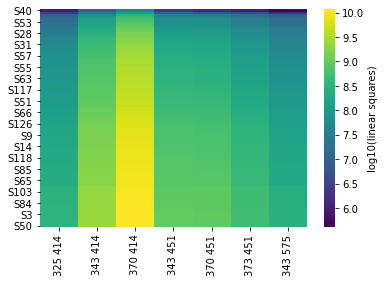

In [101]:
fig, ax = plt.subplots()

sns.heatmap(log_LLS, cbar_kws={'label': 'log10(linear squares)'}, cmap='viridis', )
ax.set(xlabel="", ylabel="")

fig.savefig('/home/yike/phd/cancer_cells_img_seq/data/unmixing/linear_squares.png',
            dpi=150, bbox_inches='tight')